In [31]:
import os
import pathlib
import rasterio
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray as rxr
import geopandas as gpd
from osgeo import gdal, osr 
import scipy.ndimage as filters
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression

In [14]:
#find your current working directory:
wd = os.getcwd()

#change your working directory:
os.chdir("/Users/jsmith/Desktop")

#split path into components
path = os.getcwd()
os.path.split(path)

#split file from path
path, file = os.path.split("/Users/jsmith/Desktop/file.txt")

#use different library to make a path object:
pathlib.Path("/Users/jsmith/Desktop/file.txt")

#Split path into just file name with pathLib:
path = pathlib.Path("/Users/jsmith/Desktop/file.txt")
print(path.name)

file.txt


In [15]:
#make ranges of numbers in lists:
list = np.arange(1,10,1).tolist()

#make a bunch of random integers in a list:
ints = np.random.randint(1,20,15)

#make a bunch of numbers that follow a normal distribution with sd = 2, mean = 27, and n = 1000:
normal = np.random.normal(27, 1, 8).tolist()

#make a 3-d array that is 2 rows by 3 columns and 3 bands deep:
arr = np.array([[[1,2,3], [1,2,3]], 
                [[4,5,6], [4,5,6]], 
                [[7,8,9], [7,8,9]]])
print(arr)

#note the order is bands, rows, columns
arr.shape

[[[1 2 3]
  [1 2 3]]

 [[4 5 6]
  [4 5 6]]

 [[7 8 9]
  [7 8 9]]]


(3, 2, 3)

In [16]:
#make a dictionary that has a few keys and values:
dict = {

    "species": ["oak", "turkey oak", "beech", "birch", "yew", "chimken", "pine", "maple"],
    "height": [10,29,39,40,50,70,40,60], 
    "dbh": normal

}

In [29]:
#turn the dictionary into a pandas dataframe:
df = pd.DataFrame.from_dict(dict)

#add an extra column of values to the dataframe:
trueDbh = [22, 50, 80, 125, 64, 40, 20, 100]
df["trueDbh"] = trueDbh

df2 = pd.DataFrame({ "species": ["oak", "turkey oak", "chicko", "birch", "yew", "chimken", "pine", "maple"],
    "latin": ["quercus", "quercus", "fagus", "betula", "taxus", "gallus", "pinus", "acer"], 
    "dbh": normal })

In [33]:
#subset the dataframe by selecting only the rows where the species is oak:
df[df["species"]== "oak"]

#subset the dataframe by selecting only the rows where the species is any type of oak:
df[df["species"].str.contains("oak")]

#subset the dataframe by selecting only the rows where the species is not oak:
df[df["species"]!= "oak"]
df[~df["species"].str.contains("oak")] #same as above, but any oak sub-species
df[df["species"].str.contains("oak")==False] #altenative way to do the above

#subset the dataframe by selecting only the heights of trees that are not oak:
df[df["species"]!= "oak"]["height"]

#subset the dataframe by selecting only the heights of first trees that isn't oak:
df[df["species"]!= "oak"]["height"].values[0]

#subset the dataframe based on two conditions: height > 40 and dbh < 120:
df[(df["height"] > 40) & (df["dbh"] < 120)]

#subset the dataframe based on two conditions: height > 40 and dbh < 120 but only take dbh:
df.loc[(df["height"] > 40) & (df["dbh"] < 120),"dbh"]

#merge df2 names to df1 based on common species name:
df.merge(df2, on = 'species', how = 'left')

#merge df2 names to df1 based on common species name and only keep the latin column from df2:
df.merge(df2[["species", "latin"]], on = 'species', how = 'left')

,species,height,dbh_x,trueDbh,latin,dbh_y
0,oak,10,25.516761,22,quercus,25.516761
1,turkey oak,29,26.929374,50,quercus,26.929374
2,beech,39,28.394155,80,NaN,NaN
3,birch,40,25.888677,125,betula,25.888677
4,yew,50,25.186962,64,taxus,25.186962
5,chimken,70,24.603778,40,gallus,24.603778
6,pine,40,27.425053,20,pinus,27.425053
7,maple,60,25.553681,100,acer,25.553681


In [24]:
df2['latin']

0    quercus
1    quercus
2      fagus
3     betula
4      taxus
5     gallus
6      pinus
7       acer
Name: latin, dtype: object

In [ ]:
#Lambda functions:
#these save a function to a variable in a single line.
#The format is: variable = lambda input: output, e.g.:
var = lambda b, c: b - c + 1
var(2,1)

#write a function that calculates the quadratic mean of two stem Dbh:
qm = lambda dbh1, dbh2: np.sqrt((dbh1**2 + dbh2**2)/2)
qm(42.1,30.5)

lambda : np.sqrt(21**2 + 34**2)/2

In [ ]:
#make a for loop that prints the species of each tree:
for index, row in df.iterrows():
    print(row["species"])

#for loop that squares the dbh of each tree and adds it as a new column
vals = []
for index, row in df.iterrows():
    sqrd = row['dbh']**2
    vals.append(sqrd)
df['dbh_sqrd'] = vals

#for loop that calculates the deviations of the dbh and trueDbh columns and calculates RMSE:
for index, row in df.iterrows():
    dev = row["dbh"] - row['trueDbh']  
    df.at[index,"deviations"] = dev #you can use df.loc too

print("The RMSE is:", round(np.sqrt(np.mean(df['deviations']**2)),2))

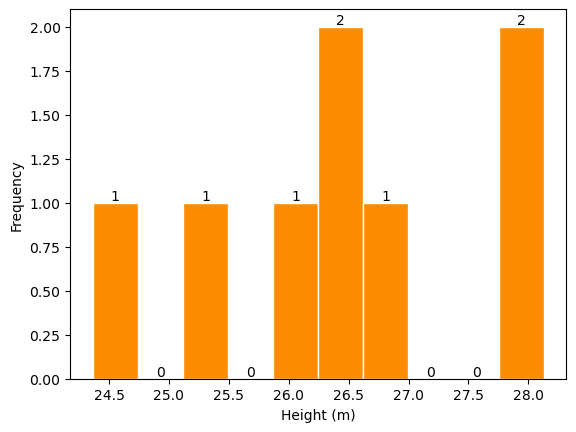

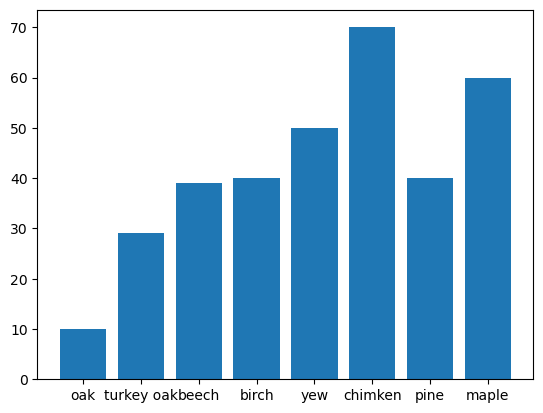

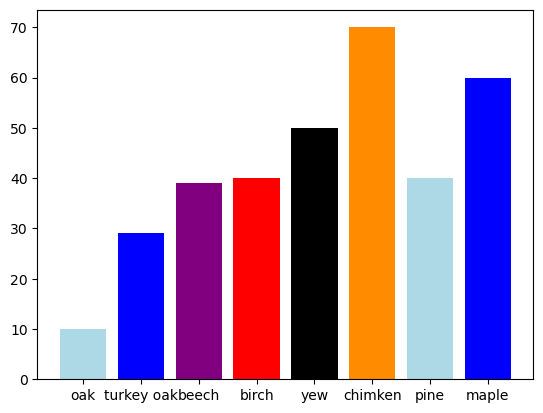

In [56]:
#Make a histogram:
plt.hist(normal, bins = 10)

#Make a fancy histogram:
values, bins, bars = plt.hist(normal, edgecolor='white', color = 'darkorange')
plt.xlabel("Height (m)")
plt.ylabel("Frequency")
plt.bar_label(bars, fontsize=10)
plt.show()

#Make a bar chart
fig, ax = plt.subplots()
ax.bar(df['species'], df['height'])
plt.show()

#make a fancy bar chart:
color = ['lightblue', 'blue', 'purple', 'red', 'black', 'darkorange']
fig, ax = plt.subplots()
ax.bar(df['species'], df['height'], color = color)
plt.show()

In [ ]:
#make a linear model:
x = df.iloc[:, 1].values.reshape(-1,1)  # values converts it into a numpy array
y = df.iloc[:, 2].values.reshape(-1,1)  # -1 means that calculate the dimension of rows, but have 1 column
y
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(x, y)  # perform linear regression
y_pred = linear_regressor.predict(x)  # make predictions

plt.scatter(x, y)
plt.plot(x, y_pred, color='red')
plt.show()

#make a power law model:
def plaw(x,a,b):
    return a * b**x

#fit model
popt, _ = curve_fit(plaw, df["height"], df["dbh"])
a, b = popt

x_line = np.arange(0, 70, 1)
y_line = plaw(x_line, a, b)
plt.scatter(df["height"], df["dbh"])
plt.plot(x_line, y_line, color='red')
plt.ylim(0,125)
plt.xlim(0,75)
plt.xlabel("Height (m)")
plt.ylabel("DBH (cm)")
plt.show()

#make an exponential model:
def exp(x,a,b):
    return a * x**b
 
popt, _ = curve_fit(exp, df["height"], df["dbh"])
a, b = popt

x_line = np.arange(0, 70, 1)
y_line = exp(x_line, a, b)
plt.scatter(df["height"], df["dbh"])
plt.plot(x_line, y_line, color='red')
plt.ylim(0,125)
plt.xlim(0,75)
plt.xlabel("Height (m)")
plt.ylabel("DBH (cm)")
plt.show()

#predict on independent data from the model:
pred_dbh = exp([1,10,15,20], a, b)

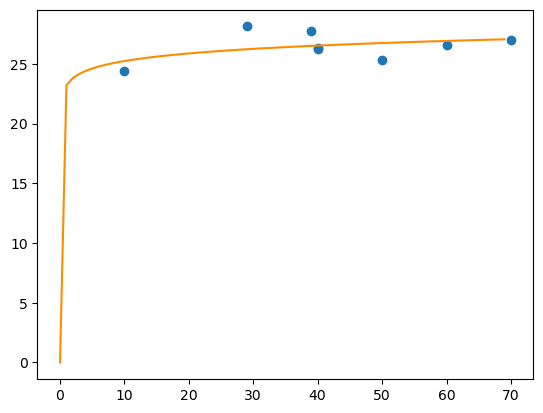

In [70]:
#power lab model

def exp(x,a,b):
    return a * x**b

popt, _ = curve_fit(exp, df["height"], df["dbh"])
a,b = popt

x_line = np.arange(0,70,1)
y_line = exp(x_line,a,b)
plt.scatter(df["height"], df["dbh"])
plt.plot(x_line, y_line, color='darkorange')
plt.show()

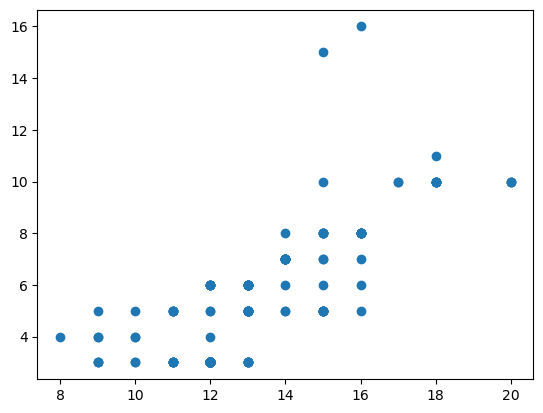

In [71]:
#import a geoJSON as a geopandas dataframe:
gdf = gpd.read_file("/Users/jsmith/Desktop/gj.geojson")

#import a shapefile as a geopandas dataframe:
gdf = gpd.read_file("/Users/jsmith/Desktop/shape.shp")

idx = gdf[gdf["field"] == gdf["field"].max()].index.values.tolist()
gdf.iloc[idx]

#remove large outlier and plot relationship between row spacing and tree spacing:
gdf.drop(idx, axis = 0, inplace = True)
plt.scatter(gdf["field"], gdf["field2"])

In [81]:
#read a raster dataset as a numpy array, apply a median filter, and write to geotiff:

ds = gdal.Open("/Users/jsmith/Desktop/chm.tif")
band = ds.GetRasterBand(1)

array = np.array(ds.GetRasterBand(1).ReadAsArray())

#apply median filter
result = filters.median_filter(array, size=5)

#get proj info 
geotransform = ds.GetGeoTransform()
wkt = ds.GetProjection()

#create shell raster
# Create gtif file
driver = gdal.GetDriverByName("GTiff")
output_file = "/Users/jsmith/Desktop/medianFilter5.tif"
dst_ds = driver.Create(output_file, band.XSize, band.YSize, 1, gdal.GDT_Int16) #1 refers to band size

#writting output raster
dst_ds.GetRasterBand(1).WriteArray(result)

#setting nodata value
dst_ds.GetRasterBand(1).SetNoDataValue(-32768.00)

#setting extension of output raster
# top left x, w-e pixel resolution, rotation, top left y, rotation, n-s pixel resolution
dst_ds.SetGeoTransform(geotransform)

# setting spatial reference of output raster
srs = osr.SpatialReference()
srs.ImportFromWkt(wkt)
dst_ds.SetProjection( srs.ExportToWkt() )

#Close output raster dataset
ds = None
dst_ds = None

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x14b0b7cf0> >

In [10]:
#alternative to gdal method for opening a raster and writing a new one:

from typing import Union
import pathlib
import rasterio
import scipy.ndimage as filters


def median_raster(in_path: Union[str, pathlib.Path], out_path: Union[str, pathlib.Path], kernelSize: int):
   import rasterio 
   import scipy.ndimage as filters

   with rasterio.open(in_path) as src:
      array = src.read(1)
      result = filters.median_filter(array, size=kernelSize)
      profile = src.profile.copy()
      profile.update(dtype=rasterio.float32)

   with rasterio.open(out_path, 'w', **profile) as dst:
      dst.write(result.astype(rasterio.float32), 1)

In [34]:
#Now, with rioxarray:

arr = rxr.open_rasterio("/Users/jsmith/Downloads/n40_w004_1arc_v3.tif")

#crs, nodata value, bounds
print("CRS is:", arr.rio.crs)
print("nodata value is:", arr.rio.nodata)
print("AOI bounds are:", arr.rio.bounds())

#show the numpy array-like thing. You can start doing band math from here.
arr.values 

#median filer
result = filters.median_filter(arr.values, size=2)
resultxr = xr.DataArray(result, coords=arr.coords, dims=arr.dims, attrs=arr.attrs)

resultxr.rio.to_raster("test.tif")
#plot
#arr.plot()

#statistics:
print("min:", arr.min().values)
print("max:", arr.max().values)
print("mean:", arr.mean().values)
print("std:",arr.std().values)
print("25th and 75th qs",arr.quantile([0.25, 0.75]).values)

CRS is: EPSG:4326
nodata value is: -32767
AOI bounds are: (-4.0001388888888885, 39.9998611111111, -2.9998611111111106, 41.000138888888884)
min: 443
max: 2417
mean: 795.7130327508612
std: 259.0308894893622
25th and 75th qs [634. 873.]


In [60]:
#try statements
#the statement under the try clause is tested for errors.
#if there is an error, the except clause is executed.
#else statement lets you execute code when there is no error.
#finally just executes code regardless of whether or not there is an error.

dogsList = ['dachsund', 'boston terrier', 'bald eagle', "dog"]

for dog in dogsList:
    try:
        if dog == "bald eagle":
            print("bald eagle is not a dog")
    except:
        print("something went wrong")
    else:
        print(dog, "is a dog")
    finally:
        print("I hope you enjoyed this dog baroOOOO!")

dachsund is a dog
I hope you enjoyed this dog baroOOOO!
boston terrier is a dog
I hope you enjoyed this dog baroOOOO!
bald eagle is not a dog
bald eagle is a dog
I hope you enjoyed this dog baroOOOO!
dog is a dog
I hope you enjoyed this dog baroOOOO!
